Fetching data from: http://barttorvik.com/2026_team_results.csv
✅ Saved 365 teams to: ../data/torvik_snapshot_2026.csv
   Last updated: 2025-12-08

Top 50 Teams by Power Score (50% AdjEM + 50% WAB):
 Power_Rank           team conf     adjEM  rank       WAB  WAB Rk  Power_Score
          1       Michigan  B10 34.117519     1  3.307460       2   103.590856
          2           Duke  ACC 29.578132     2  3.570588       1   101.010165
          3       Iowa St.  B12 27.994396     5  2.976413       3    96.943648
          4        Gonzaga  WCC 28.624789     3  2.804701       5    96.678152
          5        Arizona  B12 26.857461     8  2.876778       4    95.533245
          6     Vanderbilt  SEC 28.624060     7  2.456580       6    95.070784
          7    Connecticut   BE 27.629669     6  2.245916       9    93.267094
          8         Purdue  B10 26.818125    11  2.320686       8    92.933704
          9   Michigan St.  B10 25.982638     9  2.391255       7    92.560903
         10

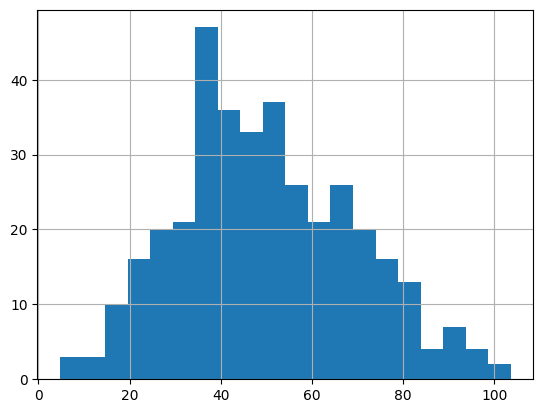

In [2]:
import pandas as pd
from datetime import date

# --- Configuration ---
SEASON_YEAR = 2026
DATA_PATH = "../data"
CSV_URL = f"http://barttorvik.com/{SEASON_YEAR}_team_results.csv"
OUTPUT_FILE = f"{DATA_PATH}/torvik_snapshot_{SEASON_YEAR}.csv"

# --- Fetch (let pandas use Bart's headers) ---
print(f"Fetching data from: {CSV_URL}")
df = pd.read_csv(CSV_URL)

# Save
df.to_csv(OUTPUT_FILE, index=False)
print(f"✅ Saved {len(df)} teams to: {OUTPUT_FILE}")
print(f"   Last updated: {date.today()}")

# --- Power Score (50% adjoe-adjde, 50% WAB) ---
# Note: "barthag" is at col 8, need to find adjEM or calculate it
# AdjEM = AdjOE - AdjDE
df['adjEM'] = df['adjoe'] - df['adjde']

df['adjEM_z'] = (df['adjEM'] - df['adjEM'].mean()) / df['adjEM'].std()
df['WAB_z'] = (df['WAB'] - df['WAB'].mean()) / df['WAB'].std()

df['Power_Score'] = (df['adjEM_z'] + df['WAB_z'] + 5) * 10
df['Power_Rank'] = df['Power_Score'].rank(ascending=False).astype(int)

# --- Display Top 50 ---
df_sorted = df.sort_values('Power_Score', ascending=False)
print("\nTop 50 Teams by Power Score (50% AdjEM + 50% WAB):")
print(df_sorted[['Power_Rank', 'team', 'conf', 'adjEM', 'rank', 'WAB', 'WAB Rk', 'Power_Score']].head(50).to_string(index=False))

# --- Make Power Score ---
print("\n--- Power Score Distribution ---")
print(df['Power_Score'].describe())

print(f"\nSkewness: {df['Power_Score'].skew():.3f}")
print(f"Kurtosis: {df['Power_Score'].kurtosis():.3f}")

# Quick histogram in terminal
print("\nHistogram:")
print(df['Power_Score'].hist(bins=20))

# Save Power Score CSV
POWER_SCORE_FILE = f"{DATA_PATH}/torvik_power_scores_{SEASON_YEAR}.csv"
df[['team', 'conf', 'adjEM', 'WAB', 'Power_Score', 'Power_Rank']].to_csv(POWER_SCORE_FILE, index=False)
print(f"\n✅ Saved Power Scores to: {POWER_SCORE_FILE}")

In [3]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import time

# Setup Chrome
options = Options()
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# Load the page
driver.get("https://barttorvik.com/teamstats.php?year=2026&sort=2")
time.sleep(5)

# Grab the table
tables = pd.read_html(driver.page_source)
df = max(tables, key=len)

driver.quit()

# Flatten multi-level column headers
df.columns = ['_'.join(str(i) for i in col).strip() for col in df.columns.values]

# Rename the first few columns
df.rename(columns={
    'Unnamed: 0_level_0_Rk': 'Rk',
    'Unnamed: 1_level_0_Team': 'Team', 
    'Unnamed: 2_level_0_Conf': 'Conf'
}, inplace=True)

# Extract just the stat value (first number) from numeric columns only
for col in df.columns:
    if col not in ['Rk', 'Team', 'Conf']:
        df[col] = df[col].astype(str).str.split().str[0]
        df[col] = pd.to_numeric(df[col], errors='coerce')

print(df.head(10))
print(df.columns.tolist())

df.to_csv(f"{DATA_PATH}/torvik_master_2026.csv", index=False)
print(f"\n✅ Saved {len(df)} teams")

C:\Users\seanm\AppData\Local\Temp\ipykernel_43804\2159312232.py:20: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(driver.page_source)


   Rk          Team  Conf  Adj. Eff._Off.  Adj. Eff._Def.  Eff. FG%_Off.  \
0   1  Colorado St.   MWC           120.4           107.8           64.5   
1   2       Liberty  CUSA           114.6           104.2           62.8   
2   3      Iowa St.   B12           121.7            93.7           62.8   
3   4         Akron   MAC           120.1           106.5           62.2   
4   5    Vanderbilt   SEC           126.8            98.2           61.2   
5   6       Belmont   MVC           110.7           101.5           61.2   
6   7      Michigan   B10           124.0            89.8           61.0   
7   8      Ohio St.   B10           119.3            99.6           61.0   
8   9  UC San Diego    BW           111.6           105.3           60.0   
9  10       Seattle   WCC           107.4           102.3           59.9   

   Eff. FG%_Def.  Turnover%_Off.  Turnover%_Def.  Off. Reb%_Off.  \
0           52.8            17.0            12.5            33.1   
1           50.3           

In [4]:
# Load both files
df_summary = pd.read_csv(f"{DATA_PATH}/torvik_snapshot_2026.csv")
df_stats = pd.read_csv(f"{DATA_PATH}/torvik_teamstats_2026.csv")

# Check column names
print("Summary columns:", df_summary.columns.tolist()[:10])
print("Stats columns:", df_stats.columns.tolist()[:10])

# Join on team name
df = df_summary.merge(df_stats, left_on='team', right_on='Team', how='left')

# Drop duplicate team column
df.drop(columns=['Team'], inplace=True)

# Save the real master
df.to_csv(f"{DATA_PATH}/torvik_master_2026.csv", index=False)

print(f"\n✅ Master table: {len(df)} teams, {len(df.columns)} columns")
print(df.columns.tolist())

Summary columns: ['rank', 'team', 'conf', 'record', 'adjoe', 'oe Rank', 'adjde', 'de Rank', 'barthag', 'rank.1']
Stats columns: ['Rk', 'Team', 'Conf', 'Adj. Eff._Off.', 'Adj. Eff._Def.', 'Eff. FG%_Off.', 'Eff. FG%_Def.', 'Turnover%_Off.', 'Turnover%_Def.', 'Off. Reb%_Off.']

✅ Master table: 365 teams, 63 columns
['rank', 'team', 'conf', 'record', 'adjoe', 'oe Rank', 'adjde', 'de Rank', 'barthag', 'rank.1', 'proj. W', 'Proj. L', 'Pro Con W', 'Pro Con L', 'Con Rec.', 'sos', 'ncsos', 'consos', 'Proj. SOS', 'Proj. Noncon SOS', 'Proj. Con SOS', 'elite SOS', 'elite noncon SOS', 'Opp OE', 'Opp DE', 'Opp Proj. OE', 'Opp Proj DE', 'Con Adj OE', 'Con Adj DE', 'Qual O', 'Qual D', 'Qual Barthag', 'Qual Games', 'FUN', 'ConPF', 'ConPA', 'ConPoss', 'ConOE', 'ConDE', 'ConSOSRemain', 'Conf Win%', 'WAB', 'WAB Rk', 'Fun Rk', 'adjt', 'Rk', 'Conf', 'Adj. Eff._Off.', 'Adj. Eff._Def.', 'Eff. FG%_Off.', 'Eff. FG%_Def.', 'Turnover%_Off.', 'Turnover%_Def.', 'Off. Reb%_Off.', 'Off. Reb%_Def.', 'FT Rate_Off.', 'F

adjoe             0
adjde             0
adjt              0
Eff. FG%_Off.     0
Eff. FG%_Def.     0
Turnover%_Off.    0
Turnover%_Def.    0
Off. Reb%_Off.    0
Off. Reb%_Def.    0
FT Rate_Off.      0
FT Rate_Def.      0
dtype: int64
Ready to cluster: 365 teams, 11 features


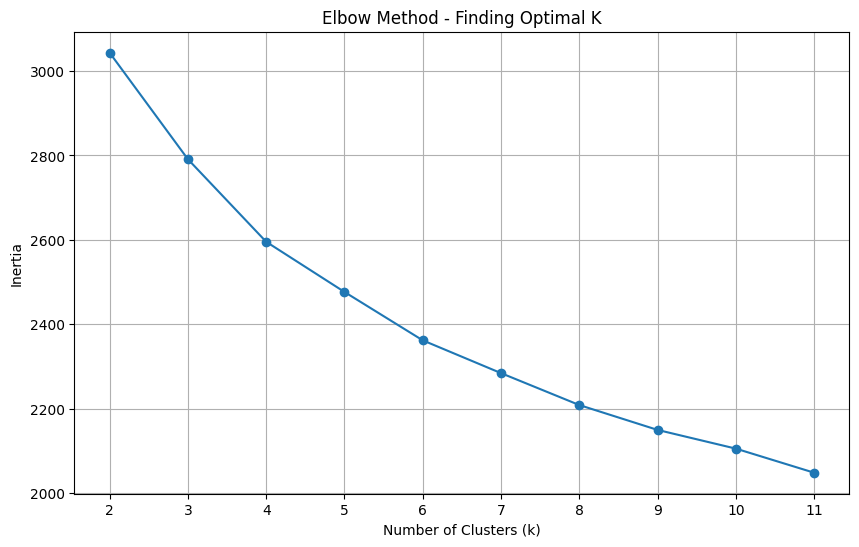

In [5]:
df = pd.read_csv(f"{DATA_PATH}/torvik_master_2026.csv")

features = [
    'adjoe', 'adjde', 'adjt',  # Efficiency + tempo
    'Eff. FG%_Off.', 'Eff. FG%_Def.',  # Shooting efficiency
    'Turnover%_Off.', 'Turnover%_Def.',  # Ball control
    'Off. Reb%_Off.', 'Off. Reb%_Def.',  # Rebounding
    'FT Rate_Off.', 'FT Rate_Def.'  # Free throw rate
]

# Check for missing values
print(df[features].isnull().sum())

# Standardize
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])

print(f"Ready to cluster: {df_scaled.shape[0]} teams, {df_scaled.shape[1]} features")

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
k_range = range(2, 12)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method - Finding Optimal K')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [14]:
# Run clustering with k=6
k = 6
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(df_scaled)

# See cluster profiles (mean of each feature by cluster)
print("Cluster Profiles:\n")
print(df.groupby('Cluster')[features].mean().round(1))

# Count teams per cluster
print("\nTeams per cluster:")
print(df['Cluster'].value_counts().sort_index())

archetype_names = {
    0: 'Elite Contenders',
    1: 'Could Get Hot', 
    2: 'Boards & Defense',
    3: 'Quality Mid-Tier',
    4: 'Rebuilders',
    5: 'Hack & Attack'
}

df['Archetype'] = df['Cluster'].map(archetype_names)

# Save the updated master file
df.to_csv(f"{DATA_PATH}/torvik_master_2026.csv", index=False)

# Quick check
print(df[['team', 'Cluster', 'Archetype', 'barthag']].sort_values('barthag', ascending=False).head(20))

Cluster Profiles:

         adjoe  adjde  adjt  Eff. FG%_Off.  Eff. FG%_Def.  Turnover%_Off.  \
Cluster                                                                     
0        118.5   99.6  69.4           56.1           47.0            15.5   
1        107.0  109.9  68.3           52.3           52.2            16.8   
2        105.4  104.6  66.7           49.4           48.4            17.9   
3        110.1  102.6  70.0           53.6           49.4            17.1   
4         99.1  112.9  68.1           46.7           54.9            20.1   
5        103.2  110.3  70.5           47.9           54.0            18.5   

         Turnover%_Def.  Off. Reb%_Off.  Off. Reb%_Def.  FT Rate_Off.  \
Cluster                                                                 
0                  17.6            36.2            28.6          38.0   
1                  15.6            27.7            30.5          34.1   
2                  17.6            33.9            29.8          34.6   

In [13]:
# Sub-cluster the elite teams (Cluster 0)
elite_mask = df['Cluster'] == 0
elite_scaled = scaler.transform(df.loc[elite_mask, features])

kmeans_elite = KMeans(n_clusters=3, random_state=42, n_init=10)
df.loc[elite_mask, 'SubCluster'] = kmeans_elite.fit_predict(elite_scaled)

# Sub-cluster the quality mid-tier (Cluster 3)
mid_mask = df['Cluster'] == 3
mid_scaled = scaler.transform(df.loc[mid_mask, features])

kmeans_mid = KMeans(n_clusters=3, random_state=42, n_init=10)
df.loc[mid_mask, 'SubCluster'] = kmeans_mid.fit_predict(mid_scaled) + 10  # offset to differentiate

# Check elite sub-clusters
print("=== ELITE CONTENDERS SUB-CLUSTERS ===\n")
for sc in [0, 1, 2]:
    print(f"--- Elite Sub-Cluster {sc} ---")
    subset = df[(df['Cluster'] == 2) & (df['SubCluster'] == sc)].sort_values('barthag', ascending=False)
    print(subset[['team', 'conf', 'adjoe', 'adjde', 'adjt', 'barthag']].head(10).to_string(index=False))
    print()

# Check mid-tier sub-clusters  
print("\n=== QUALITY MID-TIER SUB-CLUSTERS ===\n")
for sc in [10, 11, 12]:
    print(f"--- Mid-Tier Sub-Cluster {sc} ---")
    subset = df[(df['Cluster'] == 3) & (df['SubCluster'] == sc)].sort_values('barthag', ascending=False)
    print(subset[['team', 'conf', 'adjoe', 'adjde', 'adjt', 'barthag']].head(10).to_string(index=False))
    print()

# Elite sub-cluster profiles
print("=== ELITE CONTENDERS SUB-CLUSTERS ===\n")
elite_df = df[df['Cluster'] == 0]
print(elite_df.groupby('SubCluster')[features].mean().round(1))
print("\nTeams per sub-cluster:")
print(elite_df['SubCluster'].value_counts().sort_index())

# Mid-tier sub-cluster profiles
print("\n\n=== QUALITY MID-TIER SUB-CLUSTERS ===\n")
mid_df = df[df['Cluster'] == 3]
print(mid_df.groupby('SubCluster')[features].mean().round(1))
print("\nTeams per sub-cluster:")
print(mid_df['SubCluster'].value_counts().sort_index())

# Create final archetype labels
def assign_archetype(row):
    if row['Cluster'] == 0:
        if row['SubCluster'] == 0:
            return 'Ball Pressure Contender (Elite)'
        elif row['SubCluster'] == 1:
            return 'Fast to the Rack Contender (Elite)'
        elif row['SubCluster'] == 2:
            return 'Almost Contender Slow & No D (Elite)'
    elif row['Cluster'] == 3:
        if row['SubCluster'] == 10:
            return 'Shutdown D (Mid-Tier)'
        elif row['SubCluster'] == 11:
            return 'Attack the Rim (Mid-Tier)'
        elif row['SubCluster'] == 12:
            return 'Board Dominant (Mid-Tier)'
    else:
        return row['Archetype']  # Keep original for clusters 0,1,3,4

df['Archetype'] = df.apply(assign_archetype, axis=1)

# Check the distribution
print(df['Archetype'].value_counts())

# Save
df.to_csv(f"{DATA_PATH}/torvik_master_2026.csv", index=False)
print("\n✅ Saved with updated archetypes")



=== ELITE CONTENDERS SUB-CLUSTERS ===

--- Elite Sub-Cluster 0 ---
           team conf      adjoe      adjde      adjt  barthag
      Boise St.  MWC 112.576085  97.821312 67.209172 0.834187
    Mississippi  SEC 113.793703 100.923757 65.840806 0.799031
     Notre Dame  ACC 113.824246 101.466907 66.374120 0.789450
         Oregon  B10 113.350887 102.292256 68.252601 0.765042
  San Francisco  WCC 111.931653 101.517004 65.945099 0.754566
      Minnesota  B10 110.289775 102.695701 64.217519 0.694326
    Wichita St. Amer 110.264706 103.466268 66.373890 0.675209
 UNC Wilmington  CAA 111.404244 105.381429 64.100617 0.654563
St. Bonaventure  A10 109.098960 103.376161 67.274510 0.650135
     Pittsburgh  ACC 111.105479 105.356984 64.189607 0.648156

--- Elite Sub-Cluster 1 ---
             team conf      adjoe      adjde      adjt  barthag
          Memphis Amer 111.385715  99.246580 69.950669 0.790345
    Northern Iowa  MVC 106.911409  97.698983 63.846483 0.738127
        UC Irvine   BW 101.275

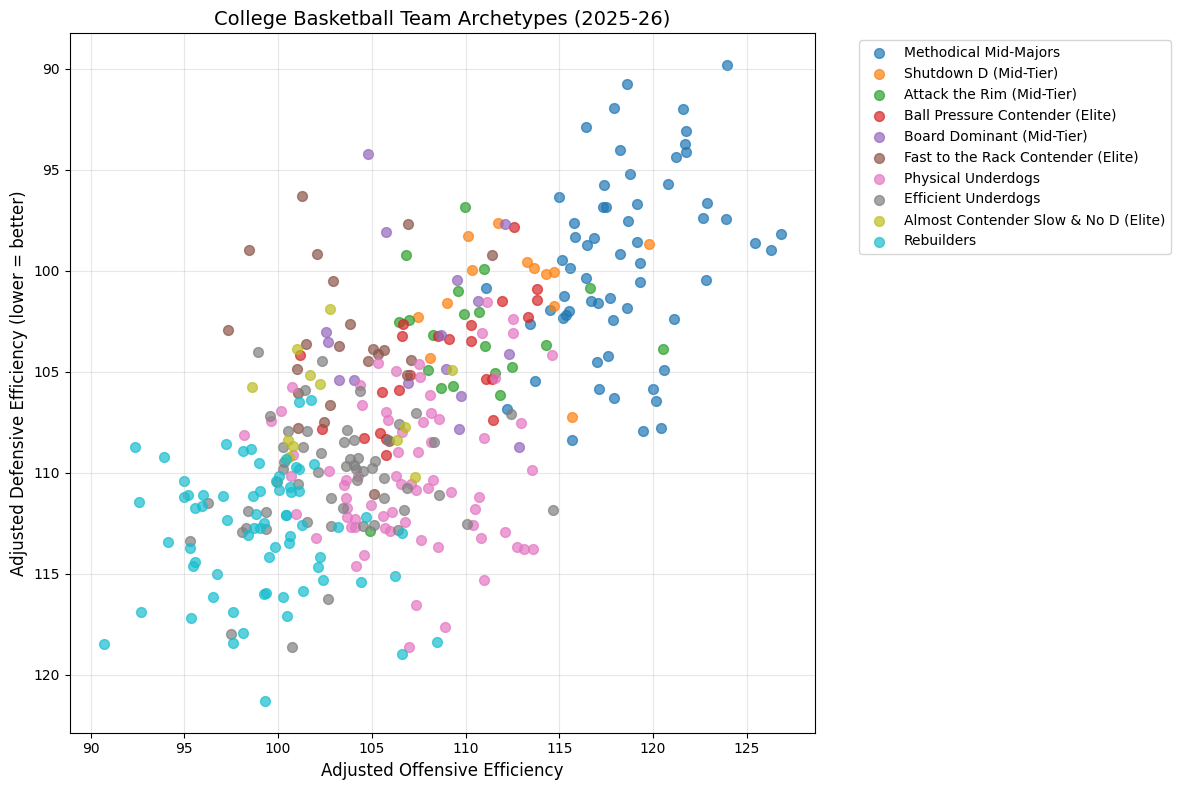

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))

# Get unique archetypes and assign colors
archetypes = df['Archetype'].unique()
colors = plt.cm.tab10(range(len(archetypes)))

for arch, color in zip(archetypes, colors):
    subset = df[df['Archetype'] == arch]
    ax.scatter(subset['adjoe'], subset['adjde'], label=arch, alpha=0.7, s=50, c=[color])

# Invert y-axis (lower adjde = better defense = higher on chart)
ax.invert_yaxis()

ax.set_xlabel('Adjusted Offensive Efficiency', fontsize=12)
ax.set_ylabel('Adjusted Defensive Efficiency (lower = better)', fontsize=12)
ax.set_title('College Basketball Team Archetypes (2025-26)', fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
import pandas as pd
import numpy as np

# Create archetype summary
archetype_summary = df.groupby('Archetype')[features].mean()

# Add team count
archetype_summary['Teams'] = df.groupby('Archetype').size()

# Add AdjEM (offensive efficiency - defensive efficiency)
archetype_summary['AdjEM'] = archetype_summary['adjoe'] - archetype_summary['adjde']

# Reorder columns to put Teams and AdjEM first
cols = ['Teams', 'AdjEM'] + features
archetype_summary = archetype_summary[cols]

# Sort by AdjEM descending
archetype_summary = archetype_summary.sort_values('AdjEM', ascending=False)

# Define which metrics are "better" when higher vs lower
higher_is_better = ['adjoe', 'AdjEM', 'Eff. FG%_Off.', 'Turnover%_Def.', 'Off. Reb%_Off.', 'FT Rate_Off.']
lower_is_better = ['adjde', 'Eff. FG%_Def.', 'Turnover%_Off.', 'Off. Reb%_Def.', 'FT Rate_Def.']

# Style function with darker colors and white text
def style_table(df):
    styles = pd.DataFrame('', index=df.index, columns=df.columns)
    
    for col in df.columns:
        if col == 'Teams' or col == 'adjt':
            continue
        mean = df[col].mean()
        std = df[col].std()
        
        for idx in df.index:
            val = df.loc[idx, col]
            z = (val - mean) / std if std > 0 else 0
            
            if col in higher_is_better:
                if z > 0.5:
                    styles.loc[idx, col] = 'background-color: #228B22; color: white'  # forest green
                elif z < -0.5:
                    styles.loc[idx, col] = 'background-color: #DC143C; color: white'  # crimson
            elif col in lower_is_better:
                if z < -0.5:
                    styles.loc[idx, col] = 'background-color: #228B22; color: white'  # forest green
                elif z > 0.5:
                    styles.loc[idx, col] = 'background-color: #DC143C; color: white'  # crimson
    
    return df.style.apply(lambda _: styles, axis=None).format(precision=1)

style_table(archetype_summary)

,Teams,AdjEM,adjoe,adjde,adjt,Eff. FG%_Off.,Eff. FG%_Def.,Turnover%_Off.,Turnover%_Def.,Off. Reb%_Off.,Off. Reb%_Def.,FT Rate_Off.,FT Rate_Def.
Archetype,,,,,,,,,,,,,
Methodical Mid-Majors,61,18.9,118.5,99.6,69.4,56.1,47.0,15.5,17.6,36.2,28.6,38.0,30.8
Shutdown D (Mid-Tier),13,11.6,112.5,100.9,69.1,53.9,48.6,16.2,23.0,32.5,33.5,38.9,38.4
Attack the Rim (Mid-Tier),20,7.1,110.4,103.3,69.5,52.5,51.1,15.8,20.7,30.5,27.6,42.9,36.4
Board Dominant (Mid-Tier),16,4.7,107.8,103.1,71.4,54.6,48.1,19.3,19.7,32.4,28.8,40.3,40.3
Ball Pressure Contender (Elite),23,4.0,108.5,104.5,66.1,50.2,49.1,17.7,17.0,36.2,28.8,35.9,31.2
Fast to the Rack Contender (Elite),23,-0.0,103.6,103.6,67.9,49.0,47.4,17.6,18.2,30.8,30.1,33.3,35.7
Physical Underdogs,72,-3.0,107.0,109.9,68.3,52.3,52.2,16.8,15.6,27.7,30.5,34.1,33.4
Almost Contender Slow & No D (Elite),12,-3.5,103.2,106.7,65.4,48.4,48.9,18.9,17.4,35.3,31.1,34.4,44.5
Efficient Underdogs,56,-7.1,103.2,110.3,70.5,47.9,54.0,18.5,18.5,31.0,33.3,38.9,43.7


In [10]:
# Find team's archetype and show their stats
team_name = "Rutgers"

team_row = df[df['team'] == team_name][['team', 'Archetype'] + features]
print(f"{team_name} is classified as: {team_row['Archetype'].values[0]}\n")

# Show their stats vs archetype average
team_stats = df[df['team'] == team_name][features].iloc[0]
archetype = df[df['team'] == team_name]['Archetype'].values[0]
archetype_avg = df[df['Archetype'] == archetype][features].mean()

comparison = pd.DataFrame({
    team_name: team_stats,
    'Archetype Avg': archetype_avg
}).T

comparison

Rutgers is classified as: Ball Pressure Contender (Elite)



,adjoe,adjde,adjt,Eff. FG%_Off.,Eff. FG%_Def.,Turnover%_Off.,Turnover%_Def.,Off. Reb%_Off.,Off. Reb%_Def.,FT Rate_Off.,FT Rate_Def.
Rutgers,106.464835,105.934782,66.140711,47.500000,50.900000,17.200000,16.900000,34.000000,33.000000,39.700000,25.200000
Archetype Avg,108.480908,104.512587,66.072136,50.247826,49.121739,17.747826,16.982609,36.217391,28.817391,35.943478,31.182609
